## **0. Introduction and References**
I decided to write this kernel when I first started learning about NLP. It is basically the things I learned documented in Kaggle Notebook format. It can be helpful for you if you are looking for **data analysis on competition data**, **feature engineering ideas for NLP**, **cleaning and text processing ideas**, **baseline BERT model** or **test set with labels**. If you have any idea that might improve this kernel, please be sure to comment, or fork and experiment as you like. If you don't understand any part, feel free to ask in the comment section.

This kernel includes codes and ideas from kernels below. If this kernel helps you, please upvote their work as well. 
* [Simple Exploration Notebook - QIQC](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) by [@sudalairajkumar](https://www.kaggle.com/sudalairajkumar)
* [How to: Preprocessing when using embeddings](https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings) by [@christofhenkel](https://www.kaggle.com/christofhenkel)
* [Improve your Score with some Text Preprocessing](https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing) by [@theoviel](https://www.kaggle.com/theoviel)
* [A Real Disaster - Leaked Label](https://www.kaggle.com/szelee/a-real-disaster-leaked-label) by [@szelee](https://www.kaggle.com/szelee)
* [Disaster NLP: Keras BERT using TFHub](https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub) by [@xhlulu](https://www.kaggle.com/xhlulu)

In [1]:
# Uncomment if it is the first run.
#!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
#!mv tokenization.py source/tokenization.py

In [2]:
!pip3 install "tensorflow_hub>=0.6.0"
!pip3 install "sentencepiece"

import os
import subprocess
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from source import tokenization
#from wordcloud import STOPWORDS   # USE nltk INSTEAD.

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# sagemaker parameters
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3

session = sagemaker.Session()
role = get_execution_role()
bucket = session.default_bucket()
prefix = 'kaggle/tweetSentiment'  # Prefix should not tontain '/' at the end!
s3 = boto3.client('s3')

# directories
working_dir = '/home/ec2-user/SageMaker/kaggle_data'
data_dir = os.path.join(working_dir, 'processed_data/')
cache_dir = os.path.join(working_dir, 'cache/')

In [4]:
df_train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


In [5]:
num_train = df_train.shape[0]
num_test = df_test.shape[0]

## **1. Keyword and Location**

### **1.1 Missing Values**
Both training and test set have same ratio of missing values in `keyword` and `location`.
* **0.8%** of `keyword` is missing in both training and test set
* **33%** of `location` is missing in both training and test set

Since missing value ratios between training and test set are too close, **they are most probably taken from the same sample**. Missing values in those features are filled with `no_keyword` and `no_location` respectively.

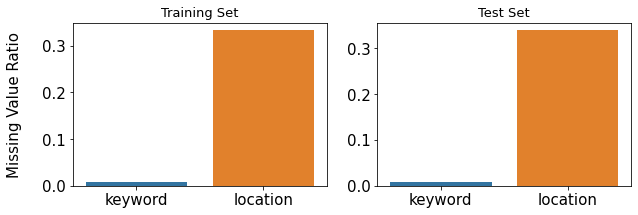

In [6]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

sns.barplot(
    x=missing_cols, 
    y=df_train[missing_cols].isnull().sum() / num_train, 
    ax=axes[0])

sns.barplot(
    x=missing_cols, 
    y=df_test[missing_cols].isnull().sum() / num_test, 
    ax=axes[1])

axes[0].set_ylabel('Missing Value Ratio', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

In [7]:
# Replace NAs.
for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

### **1.2 Cardinality and Target Distribution**
Locations are not automatically generated, they are user inputs. That's why `location` is very dirty and there are too many unique values in it. It shouldn't be used as a feature.

Fortunately, there is signal in `keyword` because some of those words can only be used in one context. Keywords have very different tweet counts and target means. `keyword` can be used as a feature by itself or as a word added to the text. Every single keyword in training set exists in test set. If training and test set are from the same sample, it is also possible to use target encoding on `keyword`.

In [8]:
print(
    'Number of unique values in keyword = Training: {} out of {} non NAs, Test: {} out of {} non NAs'.format(
        df_train["keyword"].nunique(), (df_train['keyword'] != 'no_keyword').sum(),
        df_test["keyword"].nunique(), (df_train['location'] != 'no_location').sum()
    )
)

print(
    'Number of unique values in keyword = Training: {} out of {} non NAs, Test: {} out of {} non NAs'.format(
        df_train["location"].nunique(), (df_test['keyword'] != 'no_keyword').sum(),
        df_test["location"].nunique(), (df_test['location'] != 'location').sum()
    )
)

Number of unique values in keyword = Training: 222 out of 7552 non NAs, Test: 222 out of 5080 non NAs
Number of unique values in keyword = Training: 3342 out of 3237 non NAs, Test: 1603 out of 3263 non NAs


In [9]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
df_train.head()

,id,keyword,location,text,target,target_mean
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,0.688525
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,0.688525
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,0.688525
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,0.688525
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,0.688525


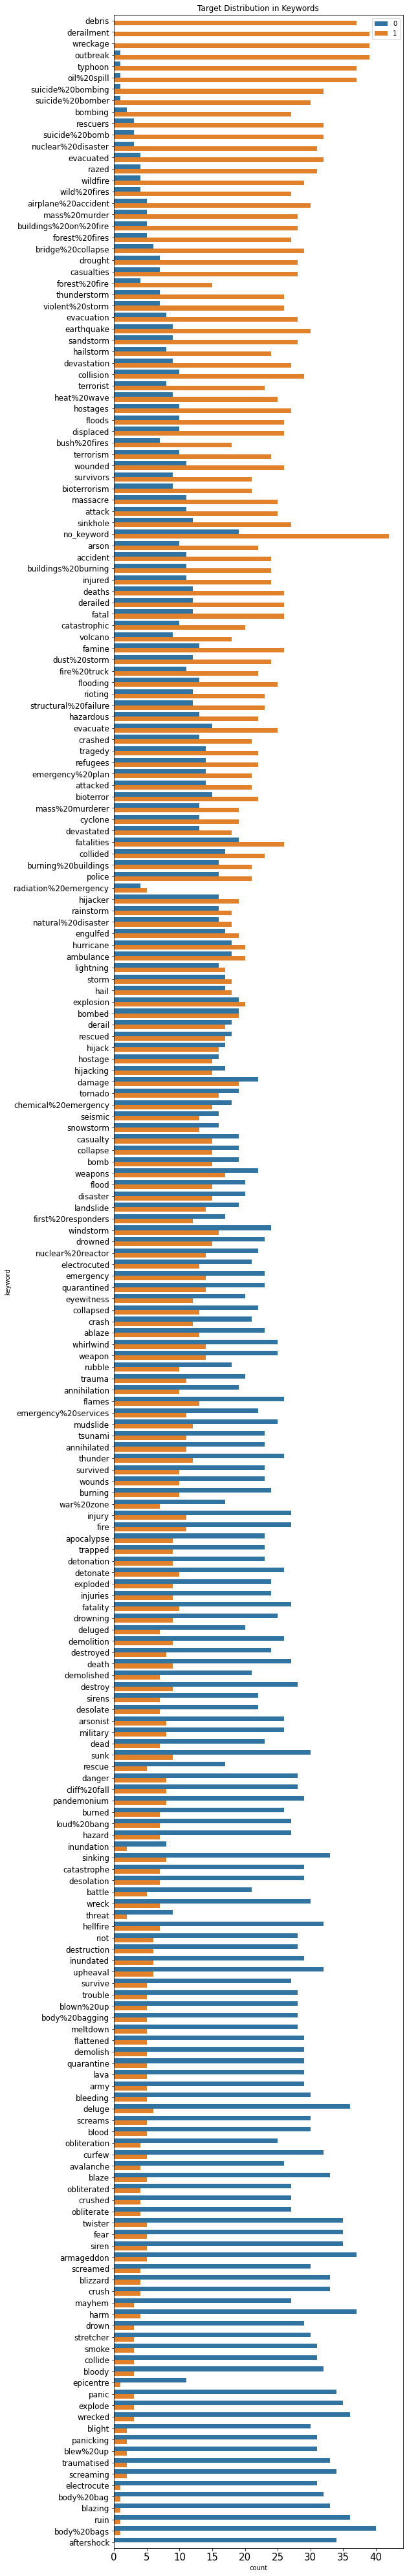

In [10]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72))

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

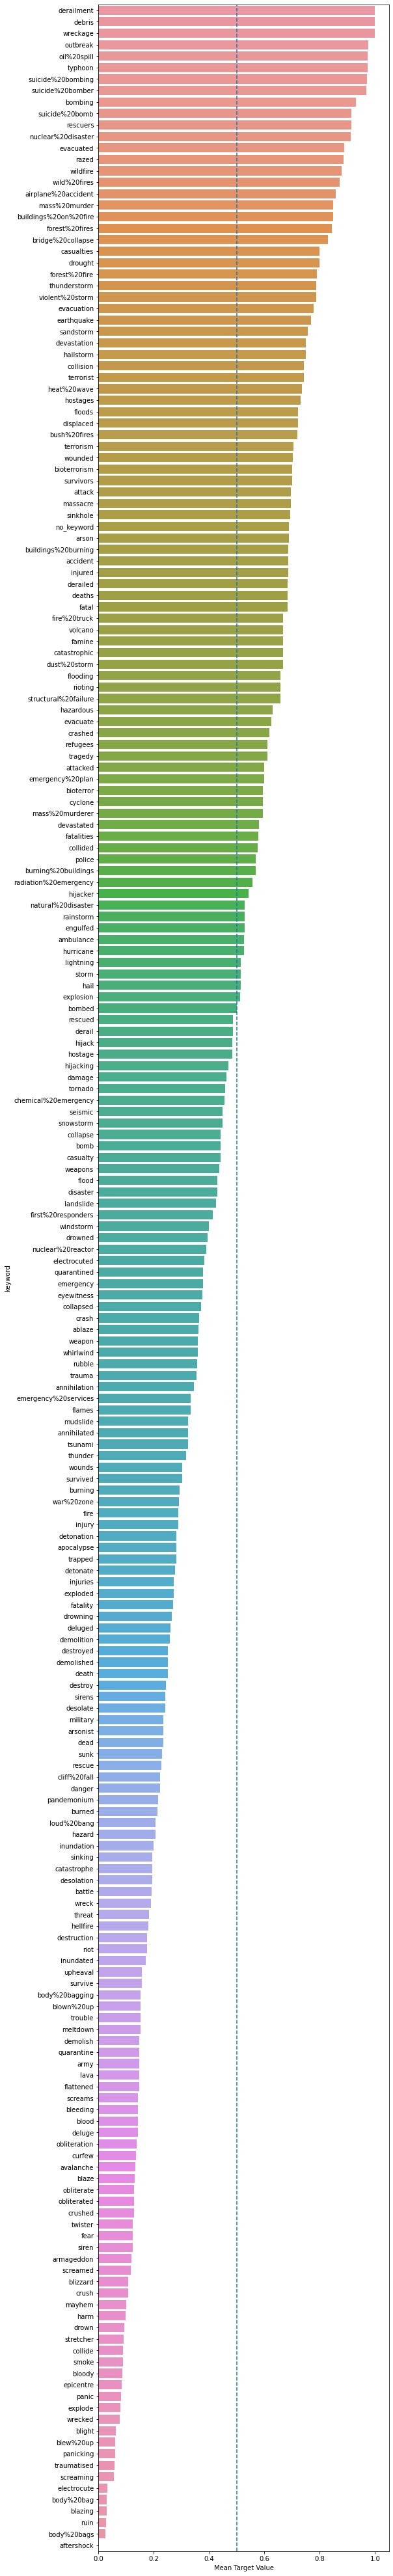

In [11]:
# Plot a ratio as an alternative.
target_mean = df_train.groupby('keyword')['target'].mean()
target_mean.sort_values(ascending=False, inplace=True)

fig = plt.figure(figsize=(8, 72))
fig = sns.barplot(x=target_mean, y=target_mean.index)
plt.axvline(0.5, linestyle='dashed')
fig.set(xlabel='Mean Target Value')

plt.show()

## **2. Meta Features**
Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The meta features used for the analysis are;
* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` number of urls in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text
* `hashtag_count` number of hashtags (**#**) in text
* `mention_count` number of mentions (**@**) in text

In [12]:
STOPWORDS = stopwords.words("english")

def make_metaFeatures(df):
    # word_count
    df['word_count'] = df['text'].apply(
        lambda x: len(str(x).split())
    )
    
    # unique_word_count
    df['unique_word_count'] = df['text'].apply(
        lambda x: len(set(str(x).split()))
    )

    # stop_word_count
    df['stop_word_count'] = df['text'].apply(
        lambda x: len(
            [w for w in str(x).lower().split() if w in STOPWORDS]
        )
    )

    # url_count
    df['url_count'] = df['text'].apply(
        lambda x: len(
            [w for w in str(x).lower().split() if 'http' in w or 'https' in w]
        )
    )

    # mean_word_length
    df['mean_word_length'] = df['text'].apply(
        lambda x: np.mean([len(w) for w in str(x).split()])
    )

    # char_count
    df['char_count'] = df['text'].apply(lambda x: len(str(x)))

    # punctuation_count
    df['punctuation_count'] = df['text'].apply(
        lambda x: len([c for c in str(x) if c in string.punctuation])
    )

    # hashtag_count
    df['hashtag_count'] = df['text'].apply(
        lambda x: len([c for c in str(x) if c == '#'])
    )

    # mention_count
    df['mention_count'] = df['text'].apply(
        lambda x: len([c for c in str(x) if c == '@'])
    )
    
    pass

In [13]:
make_metaFeatures(df_train)
make_metaFeatures(df_test)

All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample.

All of the meta features have information about target as well, but some of them are not good enough such as `url_count`, `hashtag_count` and `mention_count`.

On the other hand, `word_count`, `unique_word_count`, `stop_word_count`, `mean_word_length`, `char_count`, `punctuation_count` have very different distributions for disaster and non-disaster tweets. Those features might be useful in models.

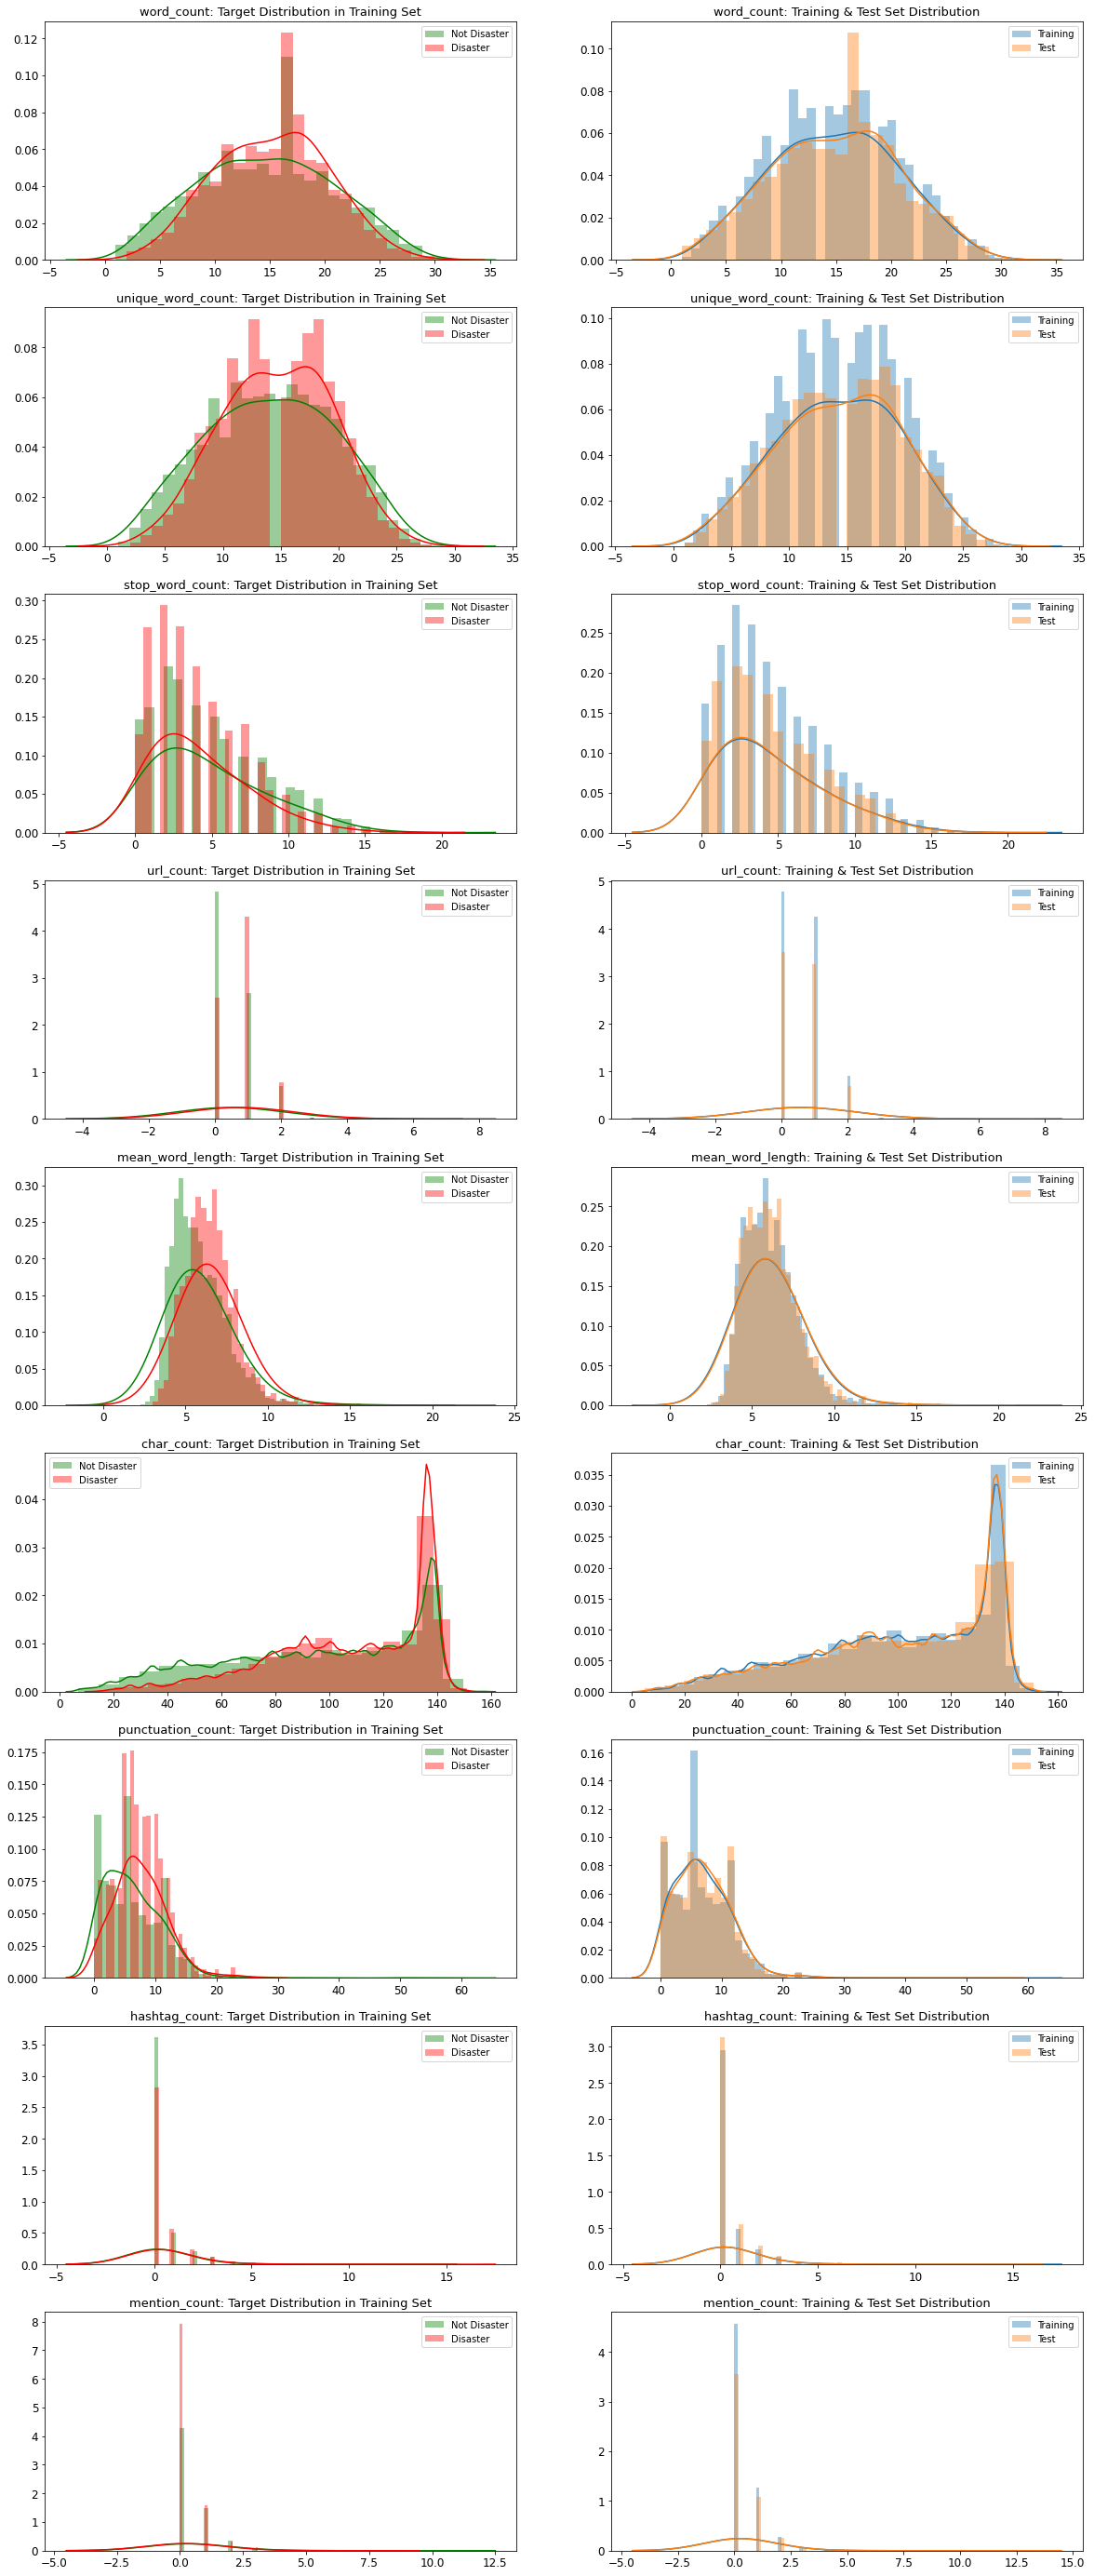

In [14]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50))

for i, feature in enumerate(METAFEATURES):
    # x axis 0
    sns.distplot(
        df_train.loc[~DISASTER_TWEETS][feature],  # for those with 'target' == 0
        label='Not Disaster', 
        ax=axes[i][0], 
        color='green', 
        kde_kws={'bw': 1.5}  # Returns an error for 'hashtag_count' and 'mention_count' without this parameter.
    )
    sns.distplot(
        df_train.loc[DISASTER_TWEETS][feature],  # for those with 'target' == 1
        label='Disaster', 
        ax=axes[i][0], 
        color='red', 
        kde_kws={'bw': 1.5}
    )
    
    # axis = 1
    sns.distplot(
        df_train[feature], 
        label='Training', 
        ax=axes[i][1], 
        kde_kws={'bw': 1.5}
    )
    sns.distplot(
        df_test[feature], 
        label='Test', 
        ax=axes[i][1], 
        kde_kws={'bw': 1.5}
    )
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title('{}: Target Distribution in Training Set'.format(feature), fontsize=13)
    axes[i][1].set_title('{}: Training & Test Set Distribution'.format(feature), fontsize=13)

plt.show()

## **3. Target and N-grams**

### **3.1 Target**
Class distributions are **57%** for **0** (Not Disaster) and **43%** for **1** (Disaster). Classes are almost equally separated so they don't require any stratification by `target` in cross-validation.

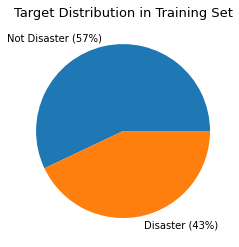

In [15]:
fig = plt.figure(figsize=(4, 4))

# pd.DataFrame.plot.pie
df_train.groupby('target').count()['id'].plot.pie(labels=['Not Disaster (57%)', 'Disaster (43%)'])

plt.ylabel('')
plt.title('Target Distribution in Training Set', fontsize=13)

plt.show()

In [16]:
def generate_ngrams(text, n_gram=1):
    token = []
    for tkn in text.lower().split(' '):
        if tkn not in STOPWORDS:
            if tkn != '':
                token.append(tkn)
                
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    
    return [' '.join(ngram) for ngram in ngrams]


def generate_df_ngrams(n_gram, df=df_train):
    disaster_ngrams = defaultdict(int)
    nondisaster_ngrams = defaultdict(int)

    # Make dictionaries.
    for tweet in df[DISASTER_TWEETS]['text']:
        for word in generate_ngrams(tweet, n_gram=n_gram):
            disaster_ngrams[word] += 1
    for tweet in df[~DISASTER_TWEETS]['text']:
        for word in generate_ngrams(tweet, n_gram=n_gram):
            nondisaster_ngrams[word] += 1

    # Make data frames.
    df_disaster_ngrams = pd.DataFrame(
        sorted(
            disaster_ngrams.items(), 
            key=lambda x: x[1]
        )[::-1]
    )
    df_nondisaster_ngrams = pd.DataFrame(
        sorted(
            nondisaster_ngrams.items(), 
            key=lambda x: x[1]
        )[::-1]
    )
    
    return df_disaster_ngrams, df_nondisaster_ngrams


# Unigrams
df_disaster_unigrams, df_nondisaster_unigrams = generate_df_ngrams(1)

# Bigrams
df_disaster_bigrams, df_nondisaster_bigrams = generate_df_ngrams(2)

# Trigrams
df_disaster_trigrams, df_nondisaster_trigrams = generate_df_ngrams(3)

### **3.2 Unigrams**
Most common unigrams exist in **both classes** are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about `target`.

Most common unigrams in **disaster** tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.

Most common unigrams in **non-disaster** tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.

In [17]:
def plot_ngrams(df1, df2, n_gram, N=100):
    fig, axes = plt.subplots(ncols=2, figsize=(18, 50))
    n_grams = {1: 'unigrams', 2: 'bigrams', 3: 'trigrams'}
    n_grams = n_grams[n_gram]

    sns.barplot(
        y=df1[0].values[:N], 
        x=df1[1].values[:N], 
        ax=axes[0], 
        color='red'
    )
    sns.barplot(
        y=df2[0].values[:N], 
        x=df2[1].values[:N], 
        ax=axes[1], 
        color='green')

    for i in range(2):
        axes[i].spines['right'].set_visible(False)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', labelsize=13)
        axes[i].tick_params(axis='y', labelsize=13)

    axes[0].set_title('Top {} most common {} in Disaster Tweets'.format(N, n_grams), fontsize=15)
    axes[1].set_title('Top {} most common {} in Non-disaster Tweets'.format(N, n_grams), fontsize=15)

    plt.show()

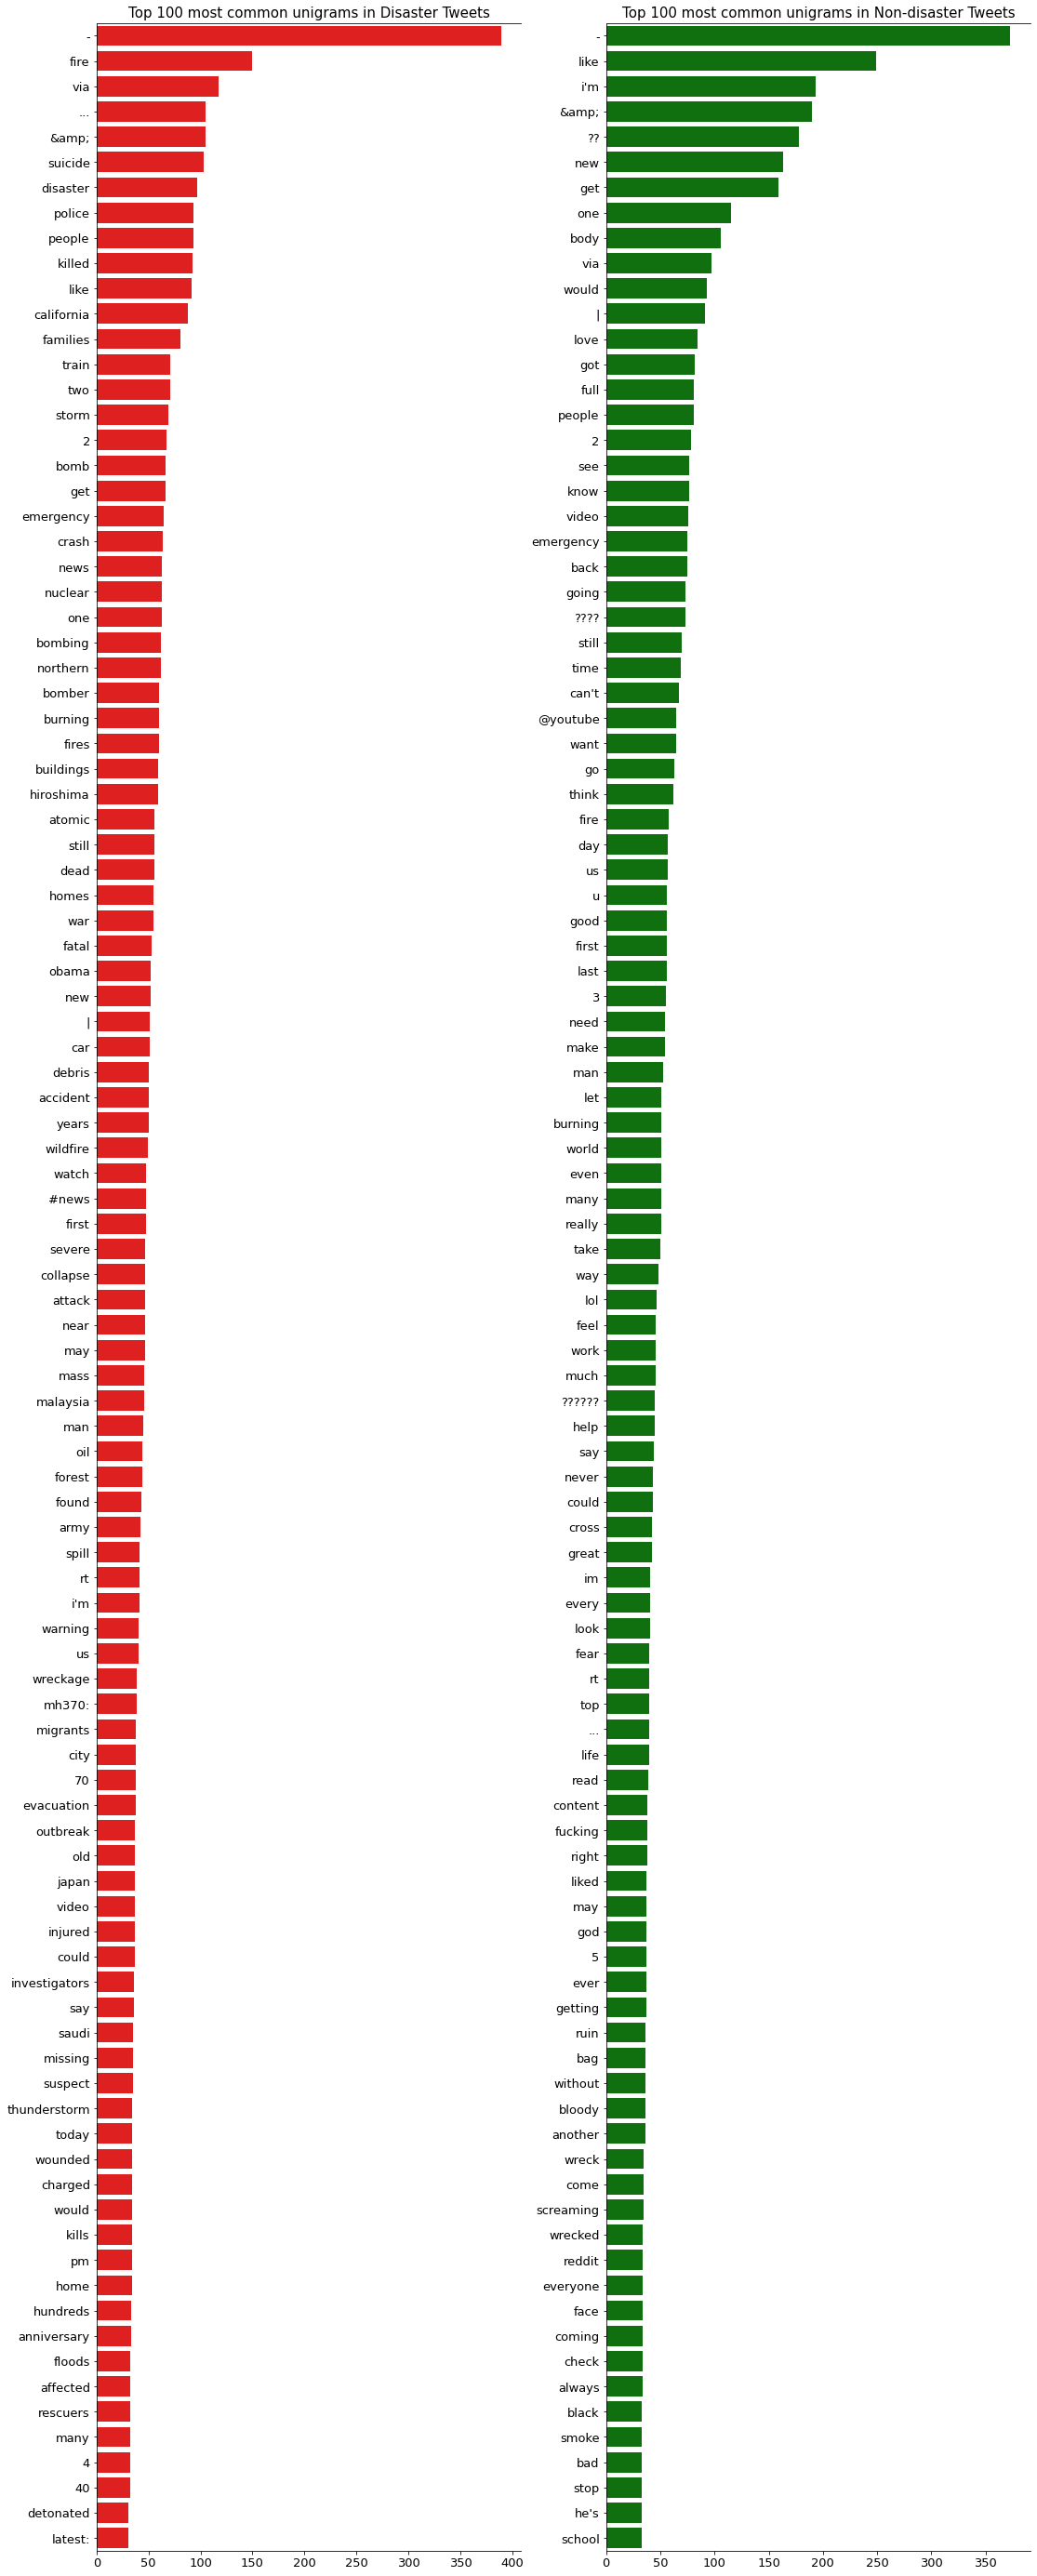

In [18]:
plot_ngrams(df_disaster_unigrams, df_nondisaster_unigrams, 1)

### **3.3 Bigrams**
There are no common bigrams exist in **both classes**  because the context is clearer.

Most common bigrams in **disaster** tweets are giving more information about the disasters than unigrams, but punctuations have to be stripped from words.

Most common bigrams in **non-disaster** tweets are mostly about reddit or youtube, and they contain lots of punctuations. Those punctuations have to be cleaned out of words as well.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


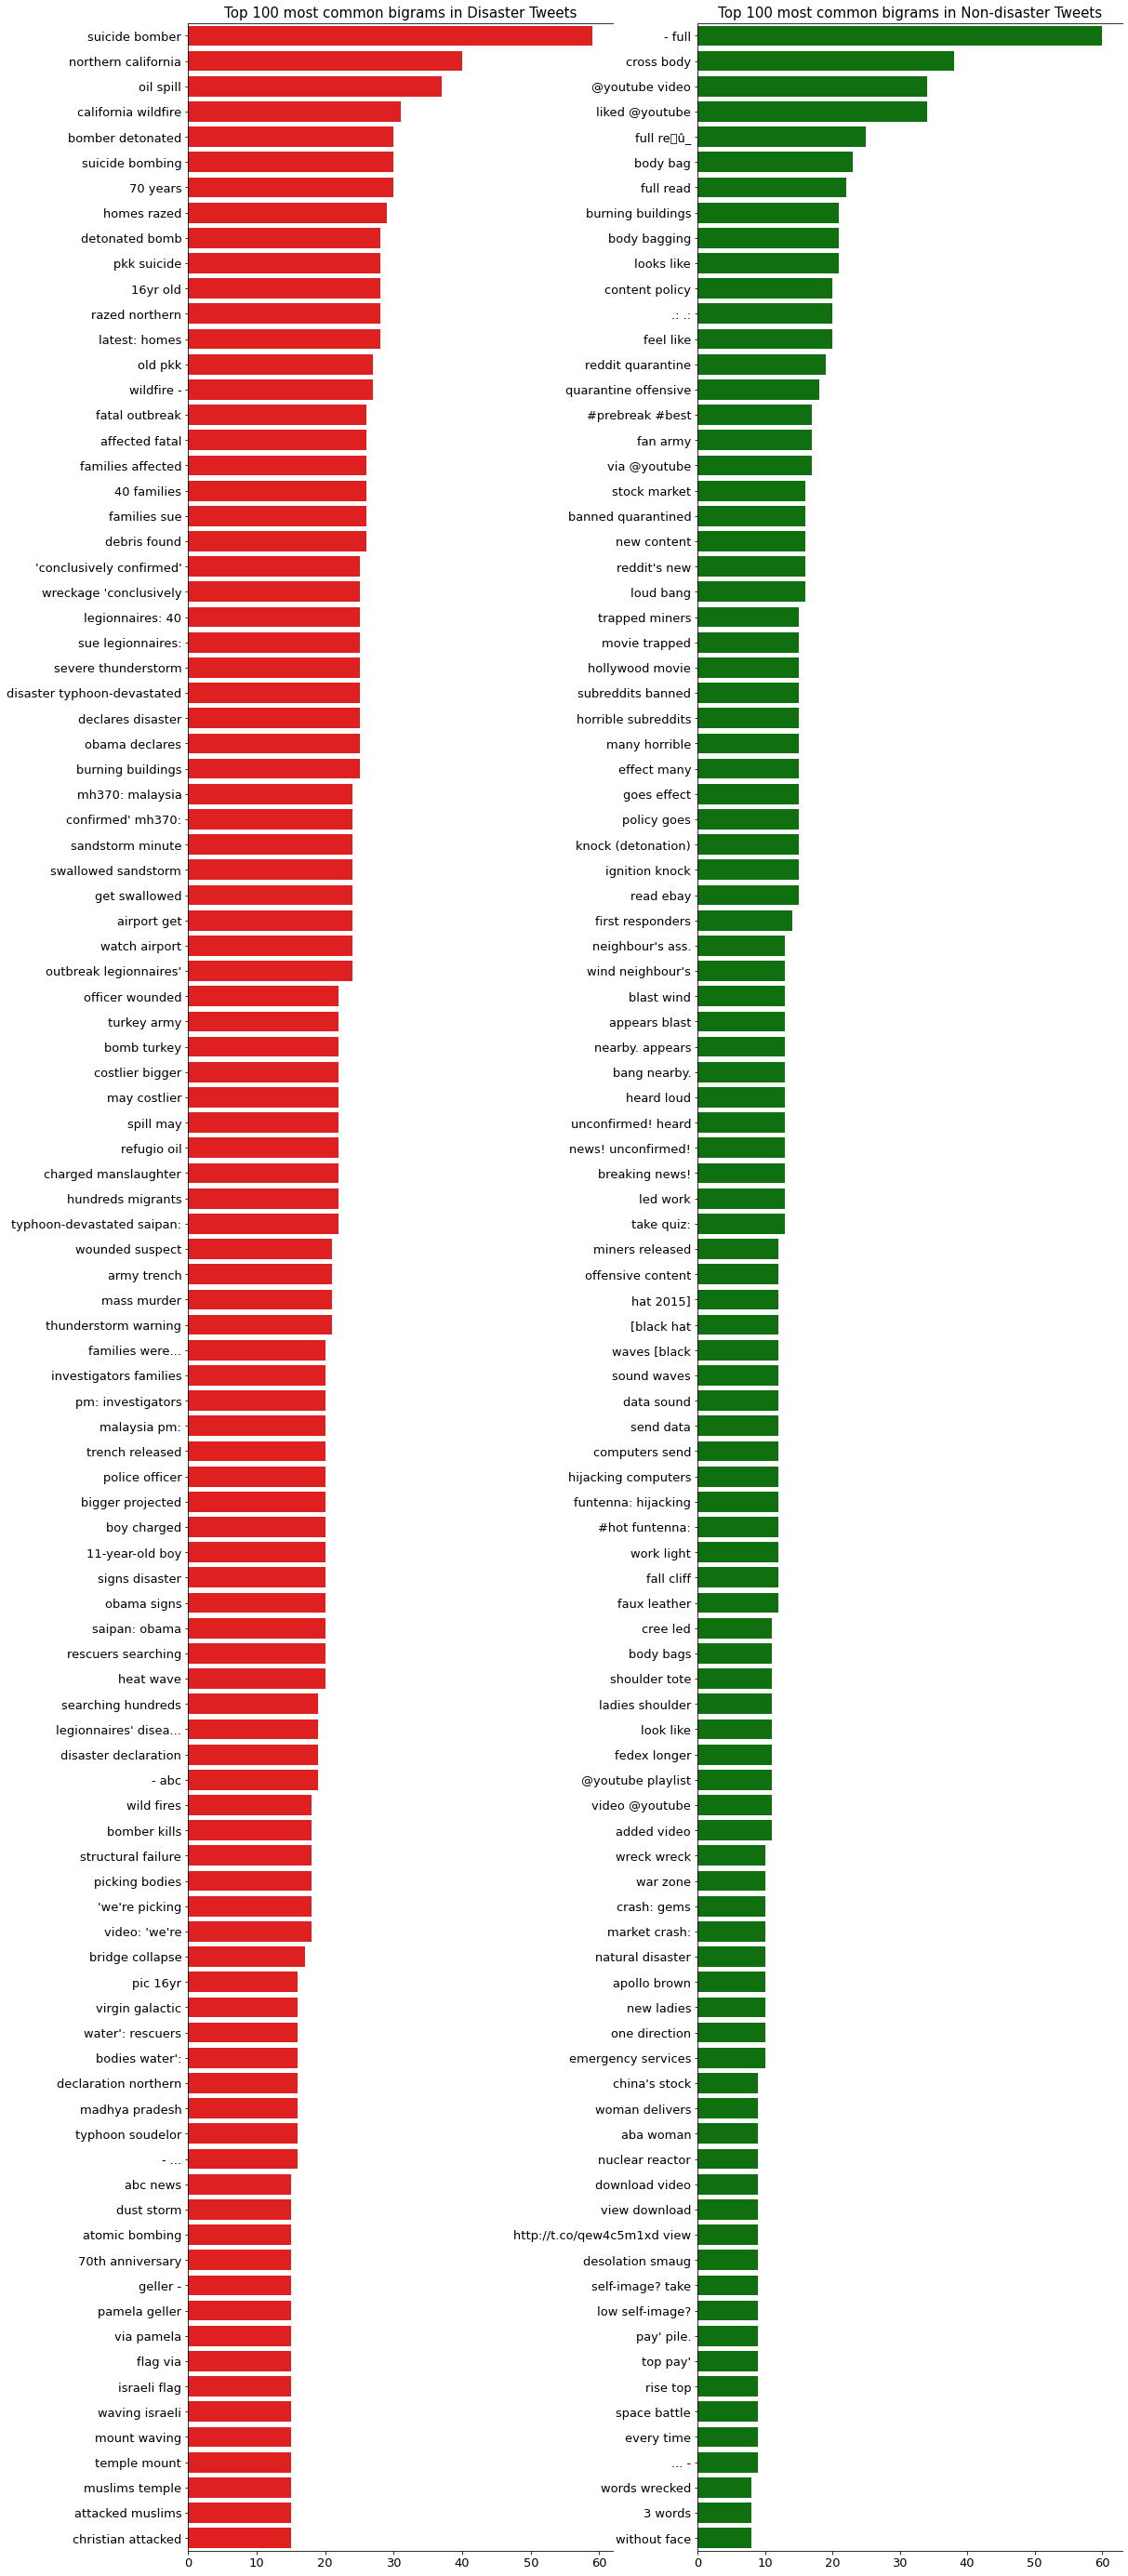

In [19]:
plot_ngrams(df_disaster_bigrams, df_nondisaster_bigrams, 2)

### **3.4 Trigrams**
There are no common trigrams exist in **both classes**  because the context is clearer.

Most common trigrams in **disaster** tweets are very similar to bigrams. They give lots of information about disasters, but they may not provide any additional information along with bigrams.

Most common trigrams in **non-disaster** tweets are also very similar to bigrams, and they contain even more punctuations.

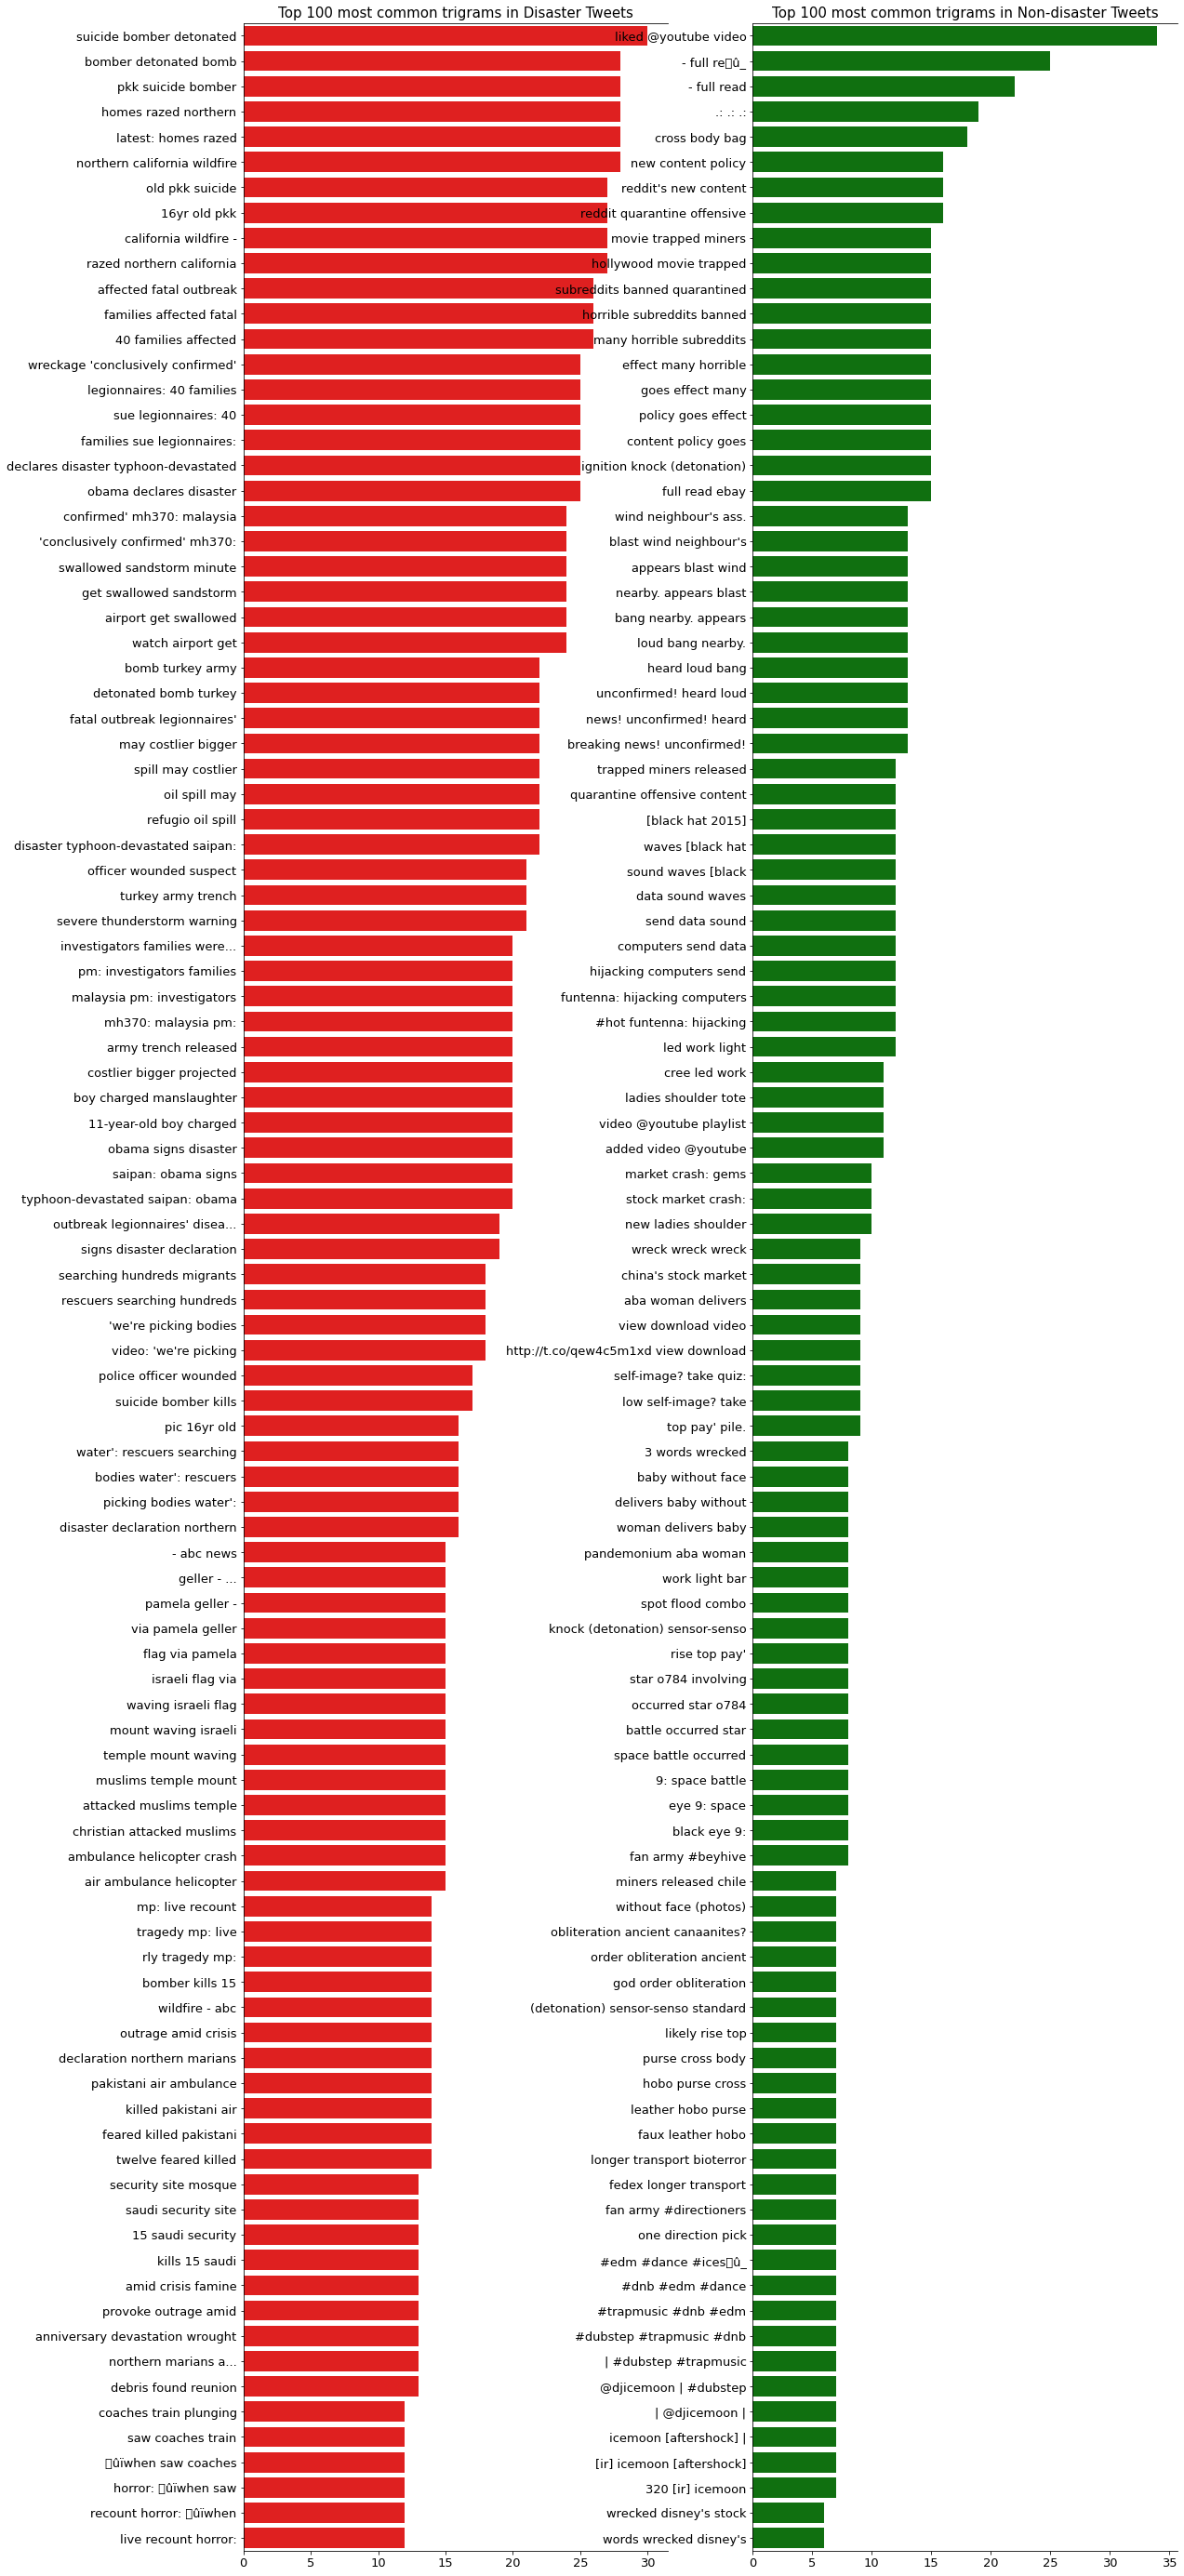

In [20]:
plot_ngrams(df_disaster_trigrams, df_nondisaster_trigrams, 3)

## **4. Embeddings and Text Cleaning**<br>

### **4.1 Embeddings Coverage**
When you have pre-trained embeddings, doing standard preprocessing steps  might not be a good idea because some of the valuable information can be lost. It is better to get vocabulary as close to embeddings as possible. In order to do that, train vocab and test vocab are created by counting the words in tweets.

Text cleaning is based on the embeddings below:
* GloVe-300d-840B
* FastText-Crawl-300d-2M<br>

#### Not enough memory in this Notebook instance, so this step is skipped.


In [21]:
"""
%%time

glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)
"""

"\n%%time\n\nglove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)\nfasttext_embeddings = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)\n"

Words in the intersection of vocab and embeddings are stored in `covered` along with their counts. Words in vocab that don't exist in embeddings are stored in `oov` along with their counts. `n_covered` and `n_oov` are total number of counts and they are used for calculating coverage percentages.

Both GloVe and FastText embeddings have more than **50%** vocabulary and **80%** text coverage without cleaning. GloVe and FastText coverage are very close but GloVe has slightly higher coverage.

In [22]:
"""
def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))
"""

"\ndef build_vocab(X):\n    \n    tweets = X.apply(lambda s: s.split()).values      \n    vocab = {}\n    \n    for tweet in tweets:\n        for word in tweet:\n            try:\n                vocab[word] += 1\n            except KeyError:\n                vocab[word] = 1                \n    return vocab\n\n\ndef check_embeddings_coverage(X, embeddings):\n    \n    vocab = build_vocab(X)    \n    \n    covered = {}\n    oov = {}    \n    n_covered = 0\n    n_oov = 0\n    \n    for word in vocab:\n        try:\n            covered[word] = embeddings[word]\n            n_covered += vocab[word]\n        except:\n            oov[word] = vocab[word]\n            n_oov += vocab[word]\n            \n    vocab_coverage = len(covered) / len(vocab)\n    text_coverage = (n_covered / (n_covered + n_oov))\n    \n    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]\n    return sorted_oov, vocab_coverage, text_coverage\n\ntrain_glove_oov, train_glove_vocab_coverage, train_glove_

### **4.2 Text Cleaning**
Tweets require lots of cleaning but it is inefficient to clean every single tweet because that would consume too much time. A general approach must be implemented for cleaning.

* The most common type of words that require cleaning in `oov` have punctuations at the start or end. Those words doesn't have embeddings because of the trailing punctuations. Punctuations `#`, `@`, `!`, `?`, `+`, `&`, `-`, `$`, `=`, `<`, `>`, `|`, `{`, `}`, `^`, `'`, `(`, `)`,`[`, `]`, `*`, `%`, `...`, `'`, `.`, `:`, `;` are separated from words
* Special characters that are attached to words are removed completely
* Contractions are expanded
* Urls are removed
* Character entity references are replaced with their actual symbols
* Typos and slang are corrected, and informal abbreviations are written in their long forms
* Some words are replaced with their acronyms and some words are grouped into one
* Finally, hashtags and usernames contain lots of information about the context but they are written without spaces in between words so they don't have embeddings. Informational usernames and hashtags should be expanded but there are too many of them. I expanded as many as I could, but it takes too much time to run `clean` function after adding those replace calls.

In [23]:
# Define a simpler cleaner.
def clean_tweet(tweet):
    tweet = re.sub(r"[,\.]", "", tweet)  # Remove ',' and '.'.
    tweet = re.sub(r"[^a-zA-Z0-9]", " ", tweet.lower()) # Convert to lower case and remove special characters.
    words = tweet.split() # Split string into words
    words = [w for w in words if w not in STOPWORDS] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # Apply porterstemmer 
    tweet_out = ' '.join(words)  # Make it back into a sentence
    
    return tweet_out

df_train['text_cleaned'] = df_train['text'].apply(lambda tweet : clean_tweet(tweet))
df_test['text_cleaned'] = df_test['text'].apply(lambda tweet : clean_tweet(tweet))

"""
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))
"""

"\ntrain_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], glove_embeddings)\ntest_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], glove_embeddings)\nprint('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))\nprint('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))\n\ntrain_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], fasttext_embeddings)\ntest_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], fasttext_embeddings)\nprint('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fast

After cleaning the tweets, `glove_embeddings` and `fasttext_embeddings` are deleted and garbage collected because they consume too much memory (10+ gigabytes).

In [24]:
"""
del glove_embeddings, fasttext_embeddings, train_glove_oov, test_glove_oov, train_fasttext_oov, test_fasttext_oov
gc.collect()
"""
print(df_train['text_cleaned'].head(10))
print(df_train.shape)

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3    13000 peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
5    rockyfir updat california hwi 20 close direct ...
6    flood disast heavi rain caus flash flood stree...
7                               top hill see fire wood
8               emerg evacu happen build across street
9                             afraid tornado come area
Name: text_cleaned, dtype: object
(7613, 15)


## **5. Mislabeled Samples**
There are **18** unique tweets in training set which are labeled differently in their duplicates. Those tweets are probably labeled by different people and they interpreted the meaning differently because some of them are not very clear. Tweets with two unique `target` values are relabeled since they can affect the training score.

In [25]:
df_duplicated = df_train.groupby(['text']).nunique()  # Number of unique items per 'text.'
df_duplicated = df_duplicated[df_duplicated['id'] > 1]  # Fetch texts to which multiple 'id's are assigned.
df_mislabeled = df_duplicated[df_duplicated['target'] > 1]  # Among them, fetch texts to which multiple 'target's are assigned.

print('Number of duplicated items in train: {}'.format(df_duplicated.shape[0]))
print('Number of mislabeled items in train: {}'.format(df_mislabeled.shape[0]))

Number of duplicated items in train: 69
Number of mislabeled items in train: 18


In [26]:
# Remove mislabeled entries.
index_mislabeled = df_train['text'].isin(df_mislabeled['text'].index.values)
df_train = df_train.loc[~index_mislabeled, :]

# Remove duplicates.
df_train.drop_duplicates('text', inplace=True)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
# Fill in empty rows. (there is one row whose text contains stopwords only.)
def fill_empty_rows(df):
    df['text_cleaned'].loc[df['text_cleaned'] == ''] = df['text'].loc[df['text_cleaned'] == '']
    return df

df_train = fill_empty_rows(df_train)
df_test = fill_empty_rows(df_test)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [28]:
df_train.to_csv('processed_data/train_for_bert.csv', index=False)
df_test.to_csv('processed_data/test_for_bert.csv', index=False)

In [29]:
# Upload the training data to S3.
session.upload_data(
    path=os.path.join(data_dir, 'train_for_bert.csv'), 
    bucket=bucket,
    key_prefix=prefix
)

'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.


's3://sagemaker-us-east-2-815596061983/kaggle/tweetSentiment/train_for_bert.csv'

In [30]:
data_location = os.path.join('s3://', bucket, prefix)

In [ ]:
train_new = True
if train_new:
    from sagemaker.tensorflow import TensorFlow
    # Initiate a TensorFlow instance.

    """When using version 2.1, 'setup.py' is needed in the 'source' directory"""

    tf_estimator = TensorFlow(
        entry_point='train_bert.py',
        source_dir='source',
        role=role,
        train_instance_count=1,
        train_instance_type='ml.p2.xlarge',
        framework_version='2.1.0',
        py_version='py3',
        output_path=os.path.join('s3://', bucket, prefix, 'model'),
        model_dir=os.path.join('s3://', bucket, prefix, 'model'),
        hyperparameters={
            'epochs': 20,
            'lr': 0.0001,
            'batch_size': 32
        }
    )
    tf_estimator.fit(data_location)
    
    model_data = tf_estimator.model_data
    subprocess.check_call('echo {} > bert_model.txt'.format(model_data), shell=True)

else:
    with open('bert_model.txt', 'r') as f:
        model_data = f.read().split()[0]
    print("Use a previously trained model.")
    
print(model_data)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-06-09 19:26:53 Starting - Starting the training job...
2020-06-09 19:26:54 Starting - Launching requested ML instances.........
2020-06-09 19:28:24 Starting - Preparing the instances for training...
2020-06-09 19:29:23 Downloading - Downloading input data......
2020-06-09 19:30:15 Training - Downloading the training image....#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153008/4491 [===================>..........] - ETA: 1:03 - loss: 0.5916 - accuracy: 0.7094#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  32/4491 [..............................] - ETA: 3:12 - loss: 0.4439 - accuracy: 0.7812#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  64/4491 [..............................] - ETA: 3:10 - loss: 0.5149 - accuracy: 0.7500#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  96/4491 [..............................] - ETA: 3:09 - loss: 0.5109 - accuracy: 0.7604#010#010#010#010#010

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153008/4491 [===================>..........] - ETA: 1:03 - loss: 0.5153 - accuracy: 0.7689#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153040/4491 [===================>..........] - ETA: 1:02 - loss: 0.5145 - accuracy: 0.7697#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  32/4491 [..............................] - ETA: 3:12 - loss: 0.4435 - accuracy: 0.7500#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  64/4491 [..............................] - ETA: 3:10 - loss: 0.4260 - accuracy: 0.7969#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  96/4491 [..............................] - ETA: 3:09 - loss: 0.4850 - accuracy: 0.7708#010#010#010#010#010

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153008/4491 [===================>..........] - ETA: 1:03 - loss: 0.4899 - accuracy: 0.7796#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153040/4491 [===================>..........] - ETA: 1:02 - loss: 0.4884 - accuracy: 0.7812#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  32/4491 [..............................] - ETA: 3:12 - loss: 0.6086 - accuracy: 0.6875#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  64/4491 [..............................] - ETA: 3:10 - loss: 0.6316 - accuracy: 0.6719#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  96/4491 [..............................] - ETA: 3:09 - loss: 0.5587 - accuracy: 0.7188#010#010#010#010#010

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153008/4491 [===================>..........] - ETA: 1:03 - loss: 0.4630 - accuracy: 0.7939#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153040/4491 [===================>..........] - ETA: 1:02 - loss: 0.4617 - accuracy: 0.7947#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  32/4491 [..............................] - ETA: 3:12 - loss: 0.4692 - accuracy: 0.8125#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  64/4491 [..............................] - ETA: 3:10 - loss: 0.4616 - accuracy: 0.7969#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  96/4491 [..............................] - ETA: 3:09 - loss: 0.4491 - accuracy: 0.8021#010#010#010#010#010

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153008/4491 [===================>..........] - ETA: 1:03 - loss: 0.4388 - accuracy: 0.8088#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153040/4491 [===================>..........] - ETA: 1:02 - loss: 0.4388 - accuracy: 0.8086#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  32/4491 [..............................] - ETA: 3:12 - loss: 0.5751 - accuracy: 0.8125#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  64/4491 [..............................] - ETA: 3:11 - loss: 0.5022 - accuracy: 0.8125#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  96/4491 [..............................] - ETA: 3:09 - loss: 0.4302 - accuracy: 0.8542#010#010#010#010#010

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153008/4491 [===================>..........] - ETA: 1:03 - loss: 0.4283 - accuracy: 0.8135#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153040/4491 [===================>..........] - ETA: 1:02 - loss: 0.4295 - accuracy: 0.8125#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  32/4491 [..............................] - ETA: 3:12 - loss: 0.4250 - accuracy: 0.7500#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  64/4491 [..............................] - ETA: 3:10 - loss: 0.4085 - accuracy: 0.7812#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  96/4491 [..............................] - ETA: 3:09 - loss: 0.4149 - accuracy: 0.7708#010#010#010#010#010

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153008/4491 [===================>..........] - ETA: 1:03 - loss: 0.4204 - accuracy: 0.8155#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153040/4491 [===================>..........] - ETA: 1:02 - loss: 0.4200 - accuracy: 0.8155#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  32/4491 [..............................] - ETA: 3:12 - loss: 0.3707 - accuracy: 0.8125#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  64/4491 [..............................] - ETA: 3:10 - loss: 0.3198 - accuracy: 0.8750#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  96/4491 [..............................] - ETA: 3:09 - loss: 0.3635 - accuracy: 0.8542#010#010#010#010#010

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153008/4491 [===================>..........] - ETA: 1:03 - loss: 0.3901 - accuracy: 0.8328#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153040/4491 [===================>..........] - ETA: 1:02 - loss: 0.3883 - accuracy: 0.8342#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  32/4491 [..............................] - ETA: 3:11 - loss: 0.3672 - accuracy: 0.8750#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  64/4491 [..............................] - ETA: 3:10 - loss: 0.3453 - accuracy: 0.8594#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  96/4491 [..............................] - ETA: 3:09 - loss: 0.3424 - accuracy: 0.8542#010#010#010#010#010

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153008/4491 [===================>..........] - ETA: 1:03 - loss: 0.3811 - accuracy: 0.8384#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153040/4491 [===================>..........] - ETA: 1:02 - loss: 0.3813 - accuracy: 0.8378#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153008/4491 [===================>..........] - ETA: 1:03 - loss: 0.2222 - accuracy: 0.9212#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153040/4491 [===================>..........] - ETA: 1:02 - loss: 0.2221 - accuracy: 0.9217#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-06-09 21:32:59,544 sagemaker-containers INFO     Reporting training SUCCESS

2020-06-09 21:33:39 Uploading - Uploading generated training model
2020-06-09 21:35:37 Completed - Training job completed
Training seconds: 7574
Billable seconds: 7574
s3://sagemaker-us-east-2-815596061983/kaggle/tweetSentiment/model/tensorflow-training-2020-06-09-19-26-52-721/output/model.tar.gz


In [ ]:
# Create a serving model.
from sagemaker.predictor import RealTimePredictor
from sagemaker.tensorflow.serving import Model

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = Model(
    model_data=model_data,
    role=role,
    framework_version='2.1',
    entry_point='inference.py',
    source_dir='source',
    #py_version='py3',
    env={'SAGEMAKER_REQUIREMENTS': 'requirements.txt'},
    predictor_cls=StringPredictor
)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!

In [ ]:
from tqdm import tqdm
pred_list = []
texts = df_test['text_cleaned'].values
for i in tqdm(range(len(texts))):
    pred = predictor.predict(texts[i])  # Make a prediction per text.
    pred_num = round(float(re.search(r'predictions.*?(\d\.\d+)', pred.decode('utf-8')).group(1)))
    pred_list.append(pred_num)

100%|██████████| 3263/3263 [46:30<00:00,  1.17it/s]


In [ ]:
# Save the output.
df_out = pd.concat([df_test['id'], pd.Series(pred_list, name='target')], axis=1)
df_out.to_csv('output/bert_out.csv', index=False)

In [ ]:
# Move it to S3.
subprocess.check_call(
    'aws s3 mv output/bert_out.csv s3://{}'.format(os.path.join(bucket, prefix, 'bert_out.csv')), 
    shell=True
)

0

In [ ]:
# Delete the endpoint.
predictor.delete_endpoint()